In [1]:
import acquire
import pandas as pd
from string import digits
import explore
import requests
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd

import re
import unicodedata
import nltk

import ngrams
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = acquire.get_github_geology_results(cached=True)
df.head()

,language,content,date
0,Jupyter Notebook,hylite\nhylite is an open-source python packag...,2020-11-27 17:31:07.762
1,Python,\n\n\n\n\n\nWebviz subsurface\n\n✨👓 Live demo ...,2020-11-27 17:31:08.305
2,R,"Reforester\nReforester, an R program that:\n\n...",2020-11-27 17:31:08.926
3,JavaScript,Swissgeol NGM\nA Geology 3D viewer\nSwissgeol ...,2020-11-27 17:31:09.532
4,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,2020-11-27 17:31:10.206


In [3]:
###################################### Clean Data Function ###############################

def basic_clean(string):
    '''
    Converts text in to ascii to remove special characters, then converts back in to utf-8
    '''
    string = (unicodedata.normalize('NFKD', string.lower())
            .encode('ascii', 'ignore') # ascii to reduce noise
            .decode('utf-8', 'ignore') # decode using utf-8
           )
    string = re.sub(r"[^a-z0-9\s]", '', string)
     # Remove numbers from text
    string = re.sub(r'\d+', '', string)
    return string
    

def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()
    
    # Use tokenizer
    string = tokenizer.tokenize(string, return_str=True)
    
    return string

def lemmatize(string):
    '''
    This function takes in string for and
    returns a string with words lemmatized.
    '''
    # Create the lemmatizer.
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Use the lemmatizer on each word in the list of words we created by using split.
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    
    # Join our list of words into a string again and assign to a variable.
    string = ' '.join(lemmas)
    
    return string


def remove_stopwords(string):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    # Create stopword_list.
    stopword_list = stopwords.words('english')
    #print(f"Lenght of stopword list before:{len(stopword_list)}")
    
    # Split words in string.
    words = string.split()
    
    # Create a list of words from my string with stopwords removed and assign to variable.
    filtered_words = [word for word in words if word not in stopword_list]
    
    # Join words in the list back into strings and assign to a variable.
    string_without_stopwords = ' '.join(filtered_words)
    return string_without_stopwords

    
def clean_data(df):
    '''
    This function takes in a dataframe of text, cleans, tokenizes, lemmatizes, and removes stopwords
    from that text, appending each step in the process to the dataframe.  It also appends a list of 
    words from each article as well as the total lenght.  
    '''    

    # Formatts repo contents to make them easier to read
    df['text_cleaned'] = df.content.apply(basic_clean)
    df['text_tokenized'] = df.text_cleaned.apply(tokenize)
    df['text_lemmatized'] = df.text_tokenized.apply(lemmatize)
    df['text_filtered'] = df.text_lemmatized.apply(remove_stopwords)
    # Add column with list of words
    words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.text_filtered]
    df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)
    # Adds column with lenght of word list
    df['doc_length'] = [len(wordlist) for wordlist in df.words]
    
    # Adds column with bigrams
    #df['bigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.ngrams(row.split(), 2)))
    df['bigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.bigrams(row.split(' '))))
    df['trigrams'] =  df['text_filtered'].apply(lambda row: list(nltk.trigrams(row.split(' '))))
    
    # Specify dataframe content
    df = df[['language','text_filtered','doc_length','words','bigrams','trigrams']]
    #df = df['language','text_filtered','words','doc_length']
    
    # removing non-english languages 
    language_list = ['JavaScript', 'R', 'Jupyter Notebook','Python','TypeScript']
    df = df[df.language.isin(language_list)]
    return df

In [4]:
df = clean_data(df)
df.head(20)

,language,text_filtered,doc_length,words,bigrams,trigrams
0,Jupyter Notebook,hylite hylite opensource python package prepro...,300,"[hylite, hylite, opensource, python, package, ...","[(hylite, hylite), (hylite, opensource), (open...","[(hylite, hylite, opensource), (hylite, openso..."
1,Python,webviz subsurface live demo application introd...,261,"[webviz, subsurface, live, demo, application, ...","[(webviz, subsurface), (subsurface, live), (li...","[(webviz, subsurface, live), (subsurface, live..."
2,R,reforester reforester r program us logistic bi...,771,"[reforester, reforesterprogram, us, logistic, ...","[(reforester, reforester), (reforester, r), (r...","[(reforester, reforester, r), (reforester, r, ..."
3,JavaScript,swissgeol ngm geology viewer swissgeol new geo...,120,"[swissgeol, ngm, geology, viewer, swissgeol, n...","[(swissgeol, ngm), (ngm, geology), (geology, v...","[(swissgeol, ngm, geology), (ngm, geology, vie..."
4,Python,geomodeldweb generates web version geological ...,174,"[geomodeldweb, generates, web, version, geolog...","[(geomodeldweb, generates), (generates, web), ...","[(geomodeldweb, generates, web), (generates, w..."
6,Jupyter Notebook,automatic rock core sample marker know marking...,47,"[automatic, rock, core, sample, marker, know, ...","[(automatic, rock), (rock, core), (core, sampl...","[(automatic, rock, core), (rock, core, sample)..."
7,TypeScript,geological model portal purpose nb fully devel...,329,"[geological, model, portal, purpose, nb, fully...","[(geological, model), (model, portal), (portal...","[(geological, model, portal), (model, portal, ..."
8,Jupyter Notebook,hylite hylite opensource python package prepro...,300,"[hylite, hylite, opensource, python, package, ...","[(hylite, hylite), (hylite, opensource), (open...","[(hylite, hylite, opensource), (hylite, openso..."
9,Python,webviz subsurface live demo application introd...,261,"[webviz, subsurface, live, demo, application, ...","[(webviz, subsurface), (subsurface, live), (li...","[(webviz, subsurface, live), (subsurface, live..."
10,R,reforester reforester r program us logistic bi...,771,"[reforester, reforesterprogram, us, logistic, ...","[(reforester, reforester), (reforester, r), (r...","[(reforester, reforester, r), (reforester, r, ..."


In [5]:
df.language.value_counts()

Python              463
Jupyter Notebook    460
R                   232
JavaScript          229
TypeScript          229
Name: language, dtype: int64

In [6]:
df.isnull().sum()

language         0
text_filtered    0
doc_length       0
words            0
bigrams          0
trigrams         0
dtype: int64

<div class="alert alert-block alert-info"><b></b></div>

***
## Hypothesis: 
`In the dicipline of Geology, specific programing languages are used for specific tasks.  In a dataset with 6 specific programing languages there should be 6 specific content groups identified using topic modeling
***

<div class="alert alert-block alert-info"><b></b></div>

## Topic Modeling:

Topic modeling is an unsupervised technique that intends to analyze large volumes of text data by clustering the documents into groups. In the case of topic modeling, the text data do not have any labels attached to it. Rather, topic modeling tries to group the documents into clusters based on similar characteristics.

A typical example of topic modeling is clustering a large number of newspaper articles that belong to the same category. In other words, cluster documents that have the same topic. It is important to mention here that it is extremely difficult to evaluate the performance of topic modeling since there are no right answers. It depends upon the user to find similar characteristics between the documents of one cluster and assign it an appropriate label or topic.

### Latent Dirichlet Allocation (LDA)

The LDA is based upon two general assumptions:

    Documents that have similar words usually have the same topic
    Documents that have groups of words frequently occurring together usually have the same topic.

These assumptions make sense because the documents that have the same topic, for instance, Business topics will have words like the "economy", "profit", "the stock market", "loss", etc. The second assumption states that if these words frequently occur together in multiple documents, those documents may belong to the same category.

Mathematically, the above two assumptions can be represented as:

    Documents are probability distributions over latent topics
    Topics are probability distributions over words


<div class="alert alert-block alert-info"><b></b></div>

#### Topic Modeling: Step One (Applying LDA)

`Before we can apply LDA, we need to create vocabulary of all the words in our data. Remember from the previous article, we could do so with the help of a count vectorizer.`

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(df['text_filtered'].values.astype('U'))
doc_term_matrix

<1613x886 sparse matrix of type '<class 'numpy.int64'>'
	with 257395 stored elements in Compressed Sparse Row format>

`Each of 2k documents is represented as 1066 dimensional vector, which means that our vocabulary has 1066 words.`

In [8]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

`In the script above we use the LatentDirichletAllocation class from the sklearn.decomposition library to perform LDA on our document-term matrix. The parameter n_components specifies the number of categories, or topics, that we want our text to be divided into. The parameter random_state (aka the seed) is set to 42 so that you get similar results each time.`

`Let's randomly fetch words from our vocabulary. We know that the count vectorizer contains all the words in our vocabulary. We can use the get_feature_names() method and pass it the ID of the word that we want to fetch.`

In [9]:
import random

for i in range(10):
    random_id = random.randint(0,len(count_vect.get_feature_names()))
    print(count_vect.get_feature_names()[random_id])

nodejs
nvclkit
potential
mainuniformsamplingr
zone
viewer
probability
correction
wa
better


`Let's find 10 words with the highest probability for the first topic. To get the first topic, you can use the components_ attribute and pass a 0 index as the value`

`The first topic contains the probabilities of 14546 words for topic To sort the indexes according to probability values, we can use the argsort() function. Once sorted, the 10 words with the highest probabilities will now belong to the last 10 indexes of the array. The following script returns the indexes of the 10 words with the highest probabilities:`

In [10]:
first_topic = LDA.components_[0]
top_topic_words = first_topic.argsort()[-10:]
top_topic_words

array([439,  95, 838, 561, 868, 639, 215, 492, 313, 268])

`These indexes can then be used to retrieve the value of the words from the count_vect object, which can be done like this`

In [11]:
for i in top_topic_words:
    print(count_vect.get_feature_names()[i])

library
clone
use
parameter
website
readme
documentation
model
gocad
file


`Let's print the 10 words with highest probabilities for all the five topics:`

In [12]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['library', 'clone', 'use', 'parameter', 'website', 'readme', 'documentation', 'model', 'gocad', 'file']


Top 10 words for topic #1:
['web', 'use', 'service', 'api', 'npm', 'server', 'directory', 'start', 'model', 'file']


Top 10 words for topic #2:
['subsurface', 'container', 'pip', 'check', 'install', 'application', 'github', 'run', 'repository', 'test']


Top 10 words for topic #3:
['tree', 'diversity', 'rate', 'data', 'time', 'using', 'sampling', 'simulation', 'run', 'fossil']


Top 10 words for topic #4:
['directory', 'library', 'using', 'gdal', 'spectral', 'import', 'python', 'data', 'install', 'hylite']




`As a final step, we will add a column to the original data frame that will store the topic for the text. To do so, we can use LDA.transform() method and pass it our document-term matrix. This method will assign the probability of all the topics to each document. Look at the following code:`

In [14]:
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape

(1613, 5)

`n the output, you will see (20000, 5) which means that each of the document has 5 columns where each column corresponds to the probability value of a particular topic. To find the topic index with maximum value, we can call the argmax() method and pass 1 as the value for the axis parameter.`

`The following script adds a new column for topic in the data frame and assigns the topic value to each row in the column:`

In [15]:
df['Topic'] = topic_values.argmax(axis=1)
df.head()

,language,text_filtered,doc_length,words,bigrams,trigrams,Topic
0,Jupyter Notebook,hylite hylite opensource python package prepro...,300,"[hylite, hylite, opensource, python, package, ...","[(hylite, hylite), (hylite, opensource), (open...","[(hylite, hylite, opensource), (hylite, openso...",4
1,Python,webviz subsurface live demo application introd...,261,"[webviz, subsurface, live, demo, application, ...","[(webviz, subsurface), (subsurface, live), (li...","[(webviz, subsurface, live), (subsurface, live...",2
2,R,reforester reforester r program us logistic bi...,771,"[reforester, reforesterprogram, us, logistic, ...","[(reforester, reforester), (reforester, r), (r...","[(reforester, reforester, r), (reforester, r, ...",3
3,JavaScript,swissgeol ngm geology viewer swissgeol new geo...,120,"[swissgeol, ngm, geology, viewer, swissgeol, n...","[(swissgeol, ngm), (ngm, geology), (geology, v...","[(swissgeol, ngm, geology), (ngm, geology, vie...",1
4,Python,geomodeldweb generates web version geological ...,174,"[geomodeldweb, generates, web, version, geolog...","[(geomodeldweb, generates), (generates, web), ...","[(geomodeldweb, generates, web), (generates, w...",0


***

#### Create wordlist for visualization

In [34]:
t0_words = ' '.join(df[df.Topic ==0].text_filtered)
t1_words = ' '.join(df[df.Topic ==1].text_filtered)
t2_words = ' '.join(df[df.Topic ==2].text_filtered)
t3_words = ' '.join(df[df.Topic ==3].text_filtered)
t4_words = ' '.join(df[df.Topic ==4].text_filtered)

***

#### Topic 0

In [19]:
topic0 =df[df.Topic == 0]
topic0.language.value_counts()

Python    231
Name: language, dtype: int64

#### Wordcloud Topic 0

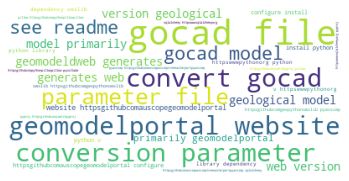

In [36]:
img = WordCloud(background_color='white').generate(t0_words)
plt.imshow(img)
plt.axis('off')
plt.show()

***

#### Topic 1

In [25]:
topic1 =df[df.Topic == 1]
topic1.language.value_counts()

TypeScript    229
JavaScript    229
Name: language, dtype: int64

***

#### Topic 2

In [24]:
topic2 =df[df.Topic == 2]
topic2.language.value_counts()

Python    232
Name: language, dtype: int64

***

#### Topic 3

In [23]:
topic3 =df[df.Topic == 3]
topic3.language.value_counts()

R                   232
Jupyter Notebook    228
Name: language, dtype: int64

***

#### Topic 4

In [26]:
topic4 =df[df.Topic == 4]
topic4.language.value_counts()

Jupyter Notebook    232
Name: language, dtype: int64

***

#### Takeaway:
Appears to be too many groups to correctly identify language, redo with 3 groups

<div class="alert alert-block alert-info"><b></b></div>

## Three Groups (Trial)

In [29]:
df = acquire.get_github_geology_results(cached=True)
df = clean_data(df)
count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(df['text_filtered'].values.astype('U'))
LDA = LatentDirichletAllocation(n_components=3, random_state=42)
LDA.fit(doc_term_matrix)
topic_values = LDA.transform(doc_term_matrix)
df['Topic'] = topic_values.argmax(axis=1)
df.head()

,language,text_filtered,doc_length,words,bigrams,trigrams,Topic
0,Jupyter Notebook,hylite hylite opensource python package prepro...,300,"[hylite, hylite, opensource, python, package, ...","[(hylite, hylite), (hylite, opensource), (open...","[(hylite, hylite, opensource), (hylite, openso...",1
1,Python,webviz subsurface live demo application introd...,261,"[webviz, subsurface, live, demo, application, ...","[(webviz, subsurface), (subsurface, live), (li...","[(webviz, subsurface, live), (subsurface, live...",2
2,R,reforester reforester r program us logistic bi...,771,"[reforester, reforesterprogram, us, logistic, ...","[(reforester, reforester), (reforester, r), (r...","[(reforester, reforester, r), (reforester, r, ...",2
3,JavaScript,swissgeol ngm geology viewer swissgeol new geo...,120,"[swissgeol, ngm, geology, viewer, swissgeol, n...","[(swissgeol, ngm), (ngm, geology), (geology, v...","[(swissgeol, ngm, geology), (ngm, geology, vie...",1
4,Python,geomodeldweb generates web version geological ...,174,"[geomodeldweb, generates, web, version, geolog...","[(geomodeldweb, generates), (generates, web), ...","[(geomodeldweb, generates, web), (generates, w...",0


In [30]:
#Topic 0
topic0 =df[df.Topic == 0]
topic0.language.value_counts()

Python    231
Name: language, dtype: int64

In [31]:
#Topic 1
topic1 =df[df.Topic == 1]
topic1.language.value_counts()

Jupyter Notebook    232
TypeScript          229
JavaScript          229
Name: language, dtype: int64

In [32]:
#Topic 2
topic2 =df[df.Topic == 2]
topic2.language.value_counts()

R                   232
Python              232
Jupyter Notebook    228
Name: language, dtype: int64